# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2021 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original Denoising AutoEncoder example from:

Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
    [Keras Denoising AutoEncoder] https://blog.keras.io/building-autoencoders-in-keras.html
</pre>

In [1]:
from tensorflow import keras

In [2]:
# ugyanaz az autoenkóder, mint az előző példában  (átmásolni ide, encoder+decoder)
autoencoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid", activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same"),
    keras.layers.Reshape([28, 28])
])

autoencoder.summary()

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          1

In [3]:
# tanítóadatok, mint az előző példában
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _) ,(x_test, _) = mnist.load_data()

print(x_train.shape, x_test.shape)

# teszt részt kettéválasztjuk még, hogy legyen külön validációs halmaz
from sklearn.model_selection import train_test_split
[x_test, x_valid] = train_test_split(x_test, test_size=0.5)

x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255

print(x_train.shape, x_valid.shape, x_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28) (5000, 28, 28) (5000, 28, 28)


In [4]:
# fehérzaj hozzákeverése az adatokhoz
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(size=x_valid.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

In [5]:
# 0-1 közé
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_valid_noisy = np.clip(x_valid_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

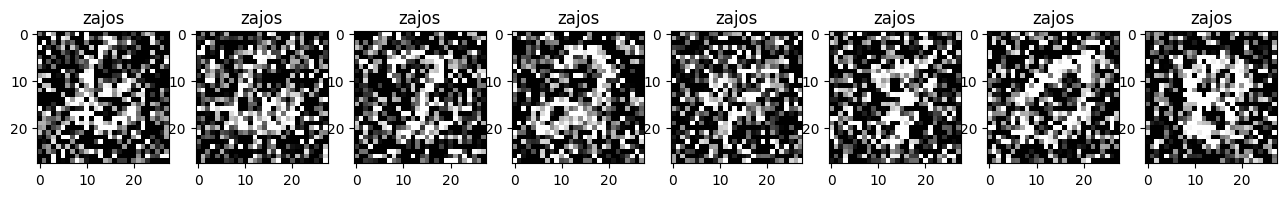

In [6]:
# zajos képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(1, n, i + 1)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

In [7]:
# tanítás
# bemenet: zajos képek
# kimenet: eredeti (zajmentes) képek
autoencoder.fit(x_train_noisy, x_train,
               epochs = 10,
               batch_size = 128,
               shuffle = True,
               validation_data = (x_valid_noisy, x_valid))

Epoch 1/10
469/469 [==============================] - 16s 8ms/step - loss: 0.0445 - val_loss: 0.0301
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0284 - val_loss: 0.0265
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0256 - val_loss: 0.0245
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0242 - val_loss: 0.0235
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0233 - val_loss: 0.0226
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0226 - val_loss: 0.0220
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0222 - val_loss: 0.0218
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0217 - val_loss: 0.0212
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0212 - val_loss: 0.020

In [8]:
decoded_imgs = autoencoder.predict(x_test_noisy)

157/157 [==============================] - 1s 3ms/step


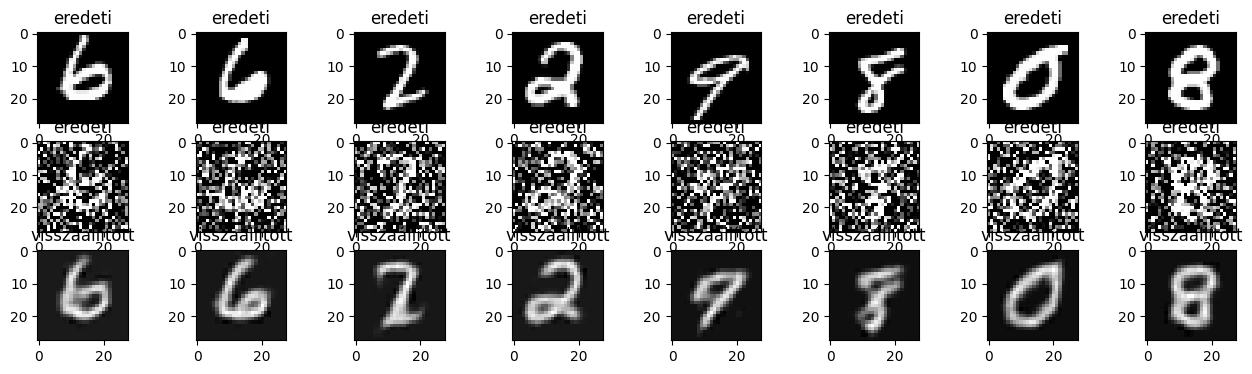

In [9]:
# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('eredeti')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
plt.show()

In [10]:
# konklúzió: zajmentesítésre használható az AE
# de: ez csak az adott zaj típusra működik jól...

157/157 [==============================] - 0s 2ms/step


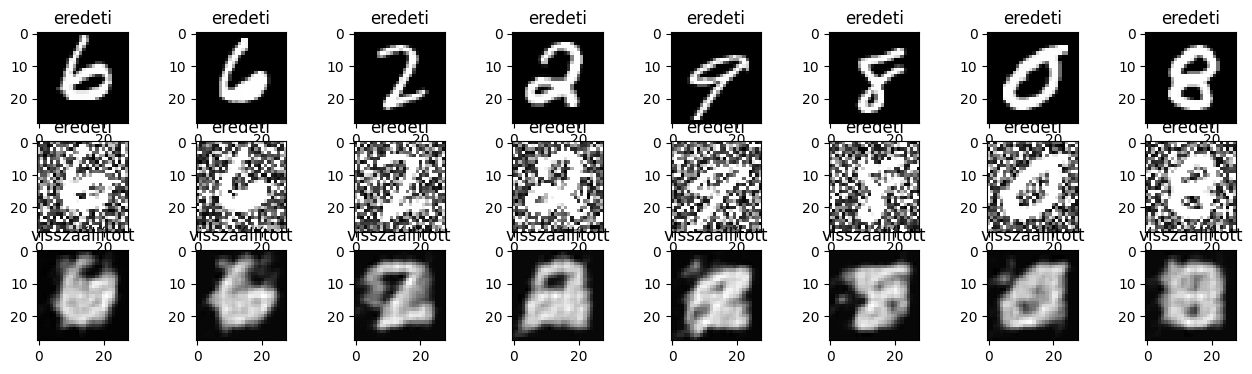

In [11]:
# más típusú zaj hozzáadása a képekhez
# szemre kb hasonlóan zajos; de mi lesz a denoising AE eredménye?
noise_factor = 0.4
x_test_noisy = x_test + noise_factor * np.random.lognormal(0, 1, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

# ez a rész ugyanaz, mint fent

decoded_imgs = autoencoder.predict(x_test_noisy)

# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('eredeti')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
plt.show()